# Bayesian Regression - Inference Algorithms and Autoguides (Part 2)

### 1. Introduction

The following simple bayesian regression example is adapted from \[1\]. We will use the dataset from \[2\], replicate the authors' central point in the paper (see below), and use this to motivate different ways of doing bayesian regression in Pyro - i.e. faster and scalable approximate inference via Variational Inference, or exact (though slower) inference via Hamiltonian Monte Carlo.

*Abstract - Ruggedness: The blessing of bad geography in Africa*


> We show that geography, through its impact on history, can have important effects on current economic development. The analysis focuses on the historic interaction between ruggedness and Africa's slave trades. Although rugged terrain hinders trade and most productive activities, negatively affecting income globally, within Africa rugged terrain afforded protection to those being raided during the slave trades. Since the slave trades retarded subsequent economic development, within Africa ruggedness has also had a historic indirect positive effect on income. Studying all countries worldwide, we estimate the differential effect of ruggedness on income for Africa. We show that the differential effect of ruggedness is statistically significant and economically meaningful, it is found in Africa only, it cannot be explained by other factors like Africa's unique geographic environment, and it is fully accounted for by the history of the slave trades.


  1. McElreath, D., *Statistical Rethinking, Chapter 7*, 2016
  2. Nunn, N. & Puga, D., *[Ruggedness: The blessing of bad geography in Africa"](https://diegopuga.org/papers/rugged.pdf)*, Review of Economics and Statistics 94(1), Feb. 2012

In [Part I](bayesian_regression.ipynb), we looked at how to perform inference on a simple Bayesian linear regression model using SVI.  In this tutorial, we'll explore more expressive guides as well as exact inference techniques.  We'll use the same dataset as before:

In [26]:
from __future__ import absolute_import, division, print_function

import argparse
from functools import partial
import logging
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import pyro
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO
from pyro.infer.abstract_infer import TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

In [27]:
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
pyro.set_rng_seed(1)
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

As can be seen from the figure above, for most nations ruggedness corresponds to lower GDP per capita. This can be attributed to multiple reasons, transporation and hence trade difficulties being the chief one. We also observe a reversal in this relationship for African nations - i.e. higher terrain ruggedness generally corresponds to higher GDP per capita. The authors posit that more rugged terrains were an important factor in protecting nations from slave traders historically, which tended to have positive effects on income later.

### 3. Bayesian Linear Regression

Let us try to use bayesian linear regression to see if we can capture and quantify this relationship. We would like to predict log GDP per capita of a nation as a function of two features from the dataset - whether the nation is in Africa, and its Terrain Ruggedness Index.

### 3.1. Model

We will write out the model again, similar to that in [Part I](bayesian_regression.ipynb), but explicitly without the use of `nn.Module`.  The reason for that will be clear later.  We'll use the same priors but this time, we will also account for a reversal in the relationship between `is_cont_africa` and `rugged` through a linear interaction term `bAR`. `bA` and `bR` are regression coefficients corresponding to  `is_cont_africa` and `ruggedness`, `a` is the intercept.

Writing down a guide will proceed in close analogy to the construction of our model, with the key difference that the guide parameters need to be trainable. To do this we register the guide parameters in the ParamStore using `pyro.param()`. 

In [31]:
def model(is_cont_africa, ruggedness):
    a = pyro.sample("a", dist.Normal(8., 1000.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.iarange("data", len(ruggedness)):
        mu = pyro.sample("mu", dist.Delta(mean))
        pyro.sample("obs", dist.Normal(mu, sigma))
        
def guide(is_cont_africa, ruggedness):
    a = pyro.sample("a", dist.Normal(8., 1000.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.iarange("data", len(ruggedness)):
        mu = pyro.sample("mu", dist.Delta(mean))
        pyro.sample("obs", dist.Normal(mu, sigma))

In [32]:
# We would like to sample "mu" after running our 
# inference routines. 
blocked_model = poutine.block(model, hide=["mu"])

In [33]:
def conditioned_model(log_gdp, *args, **kwargs):
    return poutine.condition(blocked_model, data={"obs": log_gdp})(*args, **kwargs)

In [87]:
# Utility functions

def summary(traces, sites):
    marginal = EmpiricalMarginal(traces, sites).get_samples_and_weights()[0].detach().cpu().numpy()
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

# Prepare training data
df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)

In [36]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

auto_loc tensor([ 9.1742, -1.8064, -0.1731,  0.3747, -2.2420], requires_grad=True)
auto_scale_tril tensor([[ 0.1358,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.1587,  0.1878,  0.0000,  0.0000,  0.0000],
        [-0.0651, -0.0018,  0.0512,  0.0000,  0.0000],
        [ 0.0257, -0.0489, -0.0467,  0.0763,  0.0000],
        [ 0.0050,  0.0107, -0.0041, -0.0017,  0.0661]],
       grad_fn=<ViewBackward>)


### 3.2. SVI

To fit our bayesian linear regression model, we will use Variational Inference with an automatically constructed guide that samples the latent variables from a gaussian distribution with a diagonal covariance matrix.

In [10]:
svi = SVI(conditioned_model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=Trace_ELBO(), 
          num_samples=1000)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
for i in range(10000):
    elbo = svi.step(log_gdp, is_cont_africa, ruggedness)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 711.0378744602203
Elbo loss: 562.2051142454147
Elbo loss: 540.5025819540024
Elbo loss: 556.1372277140617
Elbo loss: 431.08905851840973
Elbo loss: 475.58458638191223
Elbo loss: 420.4480336904526
Elbo loss: 348.26895451545715
Elbo loss: 263.103146314621
Elbo loss: 251.32576459646225
Elbo loss: 250.42728275060654
Elbo loss: 252.0494920015335
Elbo loss: 253.44516783952713
Elbo loss: 253.12012434005737
Elbo loss: 252.1154261827469
Elbo loss: 252.4865344762802
Elbo loss: 252.8092212677002
Elbo loss: 256.0644194483757
Elbo loss: 252.30330848693848
Elbo loss: 254.63078373670578


In [11]:
svi_diagnorm_posterior = svi.run(log_gdp, is_cont_africa, ruggedness)

Let us observe the posterior distribution over the different latent variables in the model.

In [79]:
 sum(1 for _ in svi_diagnorm_posterior._traces(log_gdp, is_cont_africa, ruggedness))

1000

In [92]:
sites = ["a", "bA", "bR", "bAR", "sigma"]

for site, values in summary(svi_diagnorm_posterior, sites).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
      mean       std        5%       25%       50%      75%       95%
0  9.17655  0.075848  9.048189  9.127528  9.176575  9.22428  9.307671 

Site: bA
       mean       std        5%       25%      50%       75%      95%
0 -1.858027  0.142452 -2.101235 -1.957869 -1.85501 -1.760963 -1.61832 

Site: bR
       mean       std        5%       25%       50%       75%      95%
0 -0.171139  0.040524 -0.236366 -0.198515 -0.172364 -0.143669 -0.10209 

Site: bAR
       mean       std        5%       25%       50%       75%       95%
0  0.365132  0.077681  0.239206  0.310348  0.365644  0.420096  0.488811 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.928539  0.053597  0.844445  0.891435  0.927459  0.961546  1.016167 



### 3.3 Exact Inference using Hamiltonian Monte Carlo

In contrast to using Variational Inference which gives us an approximate posterior over our latent variables, we can also do exact inference using MCMC. The algorithm that we will be using is called the No-U Turn Sampler (NUTS), which provides an efficient and automated way of running Hamiltonian Monte Carlo.

In [13]:
nuts_kernel = NUTS(conditioned_model, adapt_step_size=True)

hmc_posterior = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200) \
    .run(log_gdp, is_cont_africa, ruggedness)

In [14]:
for site, values in summary(hmc_posterior, sites).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%       50%       75%       95%
0  9.179603  0.136589  8.968745  9.087464  9.174021  9.265844  9.407475 

Site: bA
      mean       std        5%     25%       50%       75%       95%
0 -1.82803  0.224919 -2.212244 -1.9608 -1.821892 -1.675672 -1.475271 

Site: bR
       mean       std        5%       25%      50%     75%       95%
0 -0.185013  0.077948 -0.318752 -0.236146 -0.18432 -0.1329 -0.059205 

Site: bAR
       mean       std        5%       25%       50%       75%       95%
0  0.346066  0.135775  0.124653  0.257613  0.340219  0.436496  0.569452 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.948286  0.053496  0.862705  0.909963  0.946274  0.985496  1.036621 



### 3.4 Comparing Posterior Distributions

Let us compare the posterior distribution of the latent variables that we obtained from Variational Inference with those from Hamiltonian Monte Carlo. As can be seen below, for Variational Inference, the marginal distribution of the different regression coefficients is under-dispersed w.r.t. the true posterior (from HMC). This is an artifact of the *KL(q||p)* loss (the KL divergence of the true posterior from the approximate posterior) that is minimized by Variational Inference.

This can be better seen when we plot different cross sections from the joint posterior distribution overlaid with the approximate posterior from Variational Inference. Note that since our variational family has diagonal covariance, we cannot model any correlation between the latents.

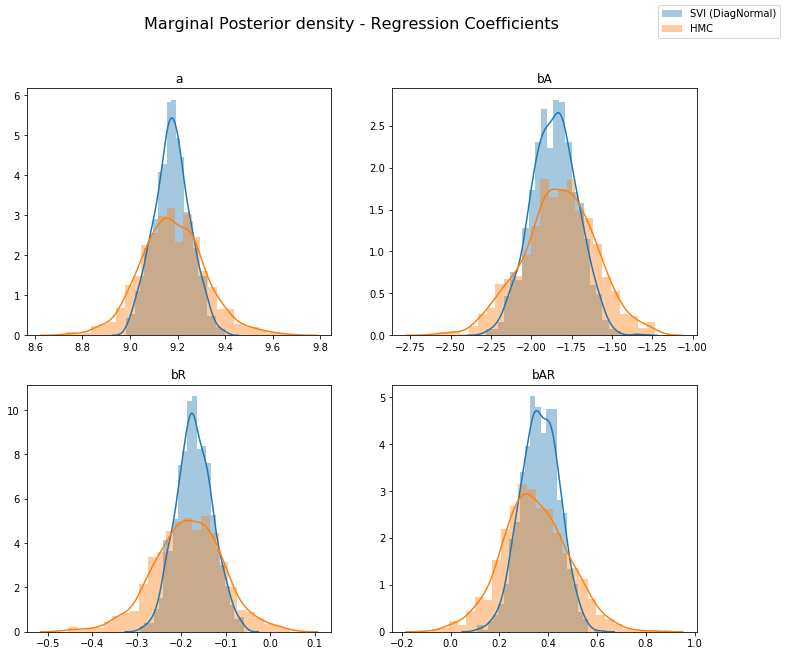

In [84]:
svi_diagnorm_empirical = EmpiricalMarginal(svi_diagnorm_posterior, sites=sites) \
                         .get_samples_and_weights()[0] \
                         .detach().cpu().numpy()
hmc_empirical = EmpiricalMarginal(hmc_posterior, sites=sites).get_samples_and_weights()[0].numpy()
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    sns.distplot(svi_diagnorm_empirical[:, i], ax=ax, label="SVI (DiagNormal)")
    sns.distplot(hmc_empirical[:, i], ax=ax, label="HMC")
    ax.set_title(sites[i])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

In [83]:
svi_diagnorm_empirical.shape

(1000, 5)

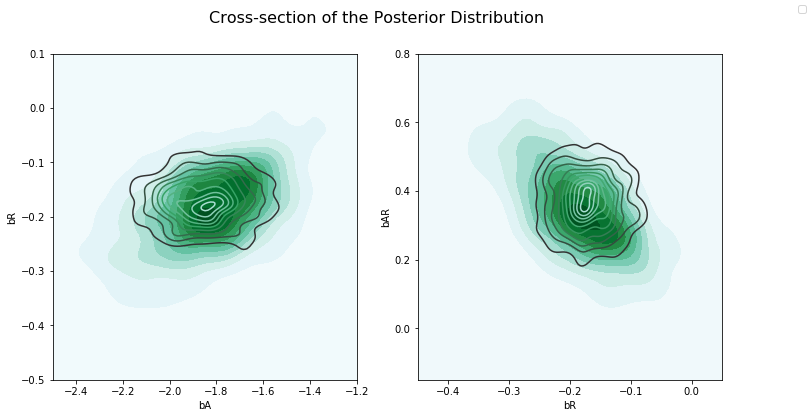

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(hmc_empirical[:, 1], hmc_empirical[:, 2], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(svi_diagnorm_empirical[:, 1], svi_diagnorm_empirical[:, 2], ax=axs[0], label="SVI (DiagNormal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(hmc_empirical[:, 2], hmc_empirical[:, 3], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(svi_diagnorm_empirical[:, 2], svi_diagnorm_empirical[:, 3], ax=axs[1], label="SVI (DiagNormal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

### 3.5 Better Posterior Approximation Using AutoMultivariateNormal Guide

As comparison to the previously obtained results from AutoDiagonalNormal guide, we will now use a guide that generates samples from a Cholesky factorization of a multivariate normal distribution.  This allows us to capture the correlations between the latent variables.  We can see that the resulting posterior distribution is closer to the true posterior.

In [17]:
guide = AutoMultivariateNormal(conditioned_model)
svi = SVI(conditioned_model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=Trace_ELBO(), 
          num_samples=1000)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
for i in range(10000):
    elbo = svi.step(log_gdp, is_cont_africa, ruggedness)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 770.6943739056587
Elbo loss: 577.581490278244
Elbo loss: 484.96705186367035
Elbo loss: 521.3715286254883
Elbo loss: 491.6360331773758
Elbo loss: 485.71347093582153
Elbo loss: 408.8069971203804
Elbo loss: 342.6060480475426
Elbo loss: 317.0384940505028
Elbo loss: 252.50462400913239
Elbo loss: 250.6135927438736
Elbo loss: 261.7659379839897
Elbo loss: 252.13346427679062
Elbo loss: 251.5525711774826
Elbo loss: 251.55952328443527
Elbo loss: 251.56655311584473
Elbo loss: 251.8454937338829
Elbo loss: 252.3315989971161
Elbo loss: 251.92085641622543
Elbo loss: 251.51784139871597


In [18]:
svi_mvn_posterior = svi.run(log_gdp, is_cont_africa, ruggedness)

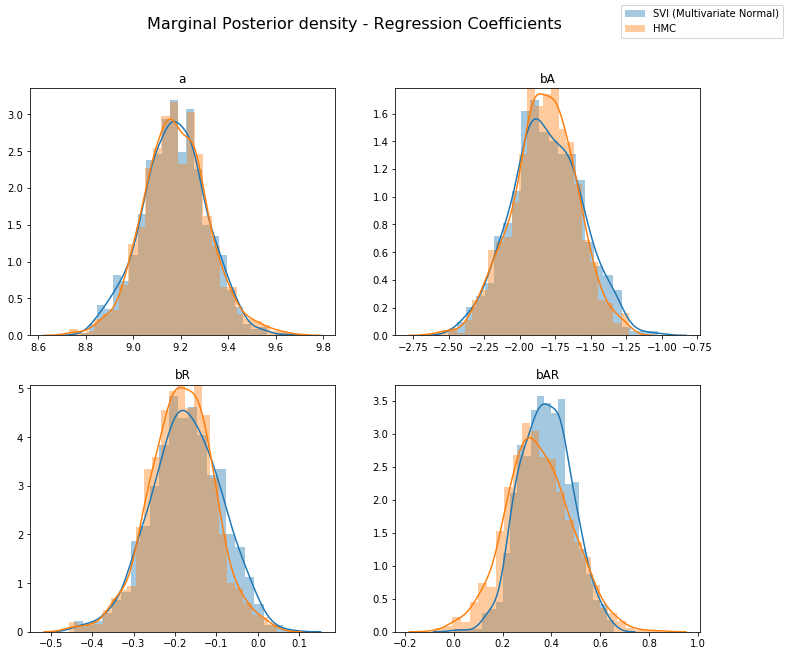

In [19]:
svi_mvn_empirical = EmpiricalMarginal(svi_mvn_posterior, sites=sites).get_samples_and_weights()[0] \
                    .detach().cpu().numpy()
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    sns.distplot(svi_mvn_empirical[:, i], ax=ax, label="SVI (Multivariate Normal)")
    sns.distplot(hmc_empirical[:, i], ax=ax, label="HMC")
    ax.set_title(sites[i])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

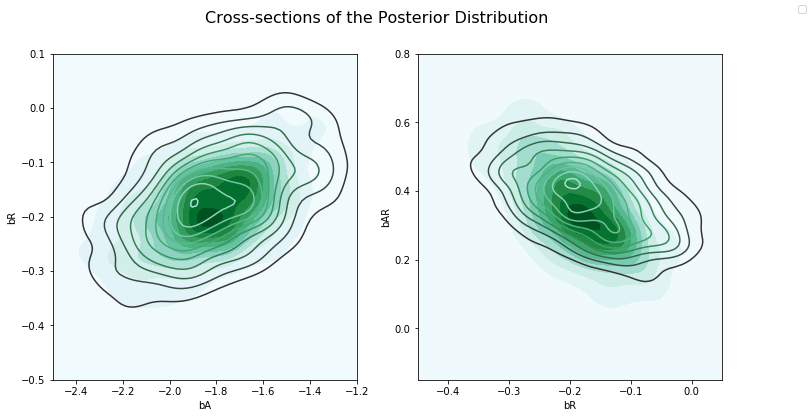

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(hmc_empirical[:, 1], hmc_empirical[:, 2], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(svi_mvn_empirical[:, 1], svi_mvn_empirical[:, 2], ax=axs[0], label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(hmc_empirical[:, 2], hmc_empirical[:, 3], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(svi_mvn_empirical[:, 2], svi_mvn_empirical[:, 3], ax=axs[1], label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

### 4. Model Predictions

Let us plot the predictions from HMC (results are similar for SVI with AutoMultivariateNormal guide). 

In [94]:
trace_pred = TracePredictive(model,
#                              hmc_posterior,
                             svi_diagnorm_posterior,
                             num_samples=1000)
post_pred = trace_pred.run(is_cont_africa, ruggedness)
post_summary = summary(post_pred, sites=["mu", "obs"])
mu = post_summary["mu"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": train[:, 0],
    "rugged": train[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": train[:, 2]
})

In [98]:
y['mean'].max()

9.2029905319213867

### 4.1 Log GDP prediction for Africa and Non Africa

Let us plot the distribution of the regression line (`"mu"` in the model), for African and non-African nations separately. 

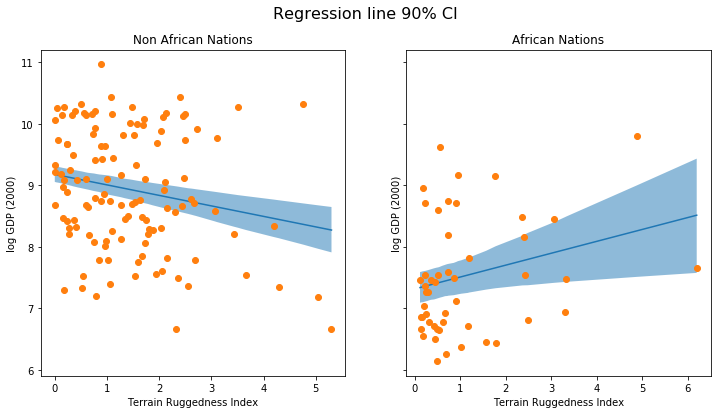

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"], 
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"], 
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"], 
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

The above figure shows the uncertainty in our estimate of the regression line. Note that for lower values of ruggedness there are many more data points, and as such, lesser wiggle room for the line of best fit. This is reflected in the 90% CI around the mean. We can also see that most of the data points actually lie outside the 90% CI, and this is expected because we have not plotted the outcome variable which will be affected by `sigma`! Let us do so next.

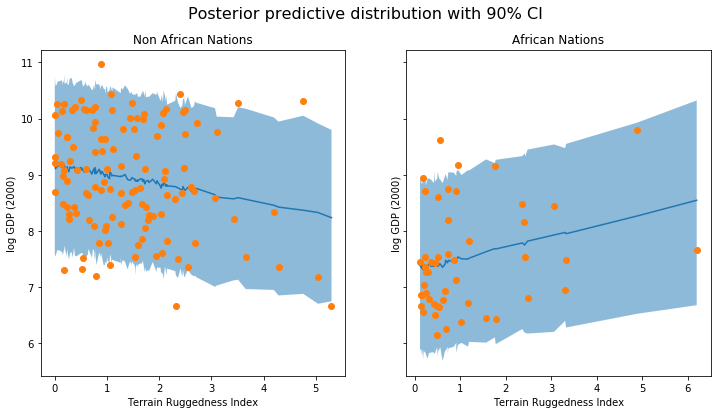

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], 
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"], 
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"], 
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

We observe that the outcome from our model and the 90% CI accounts for the majority of the data points that we observe in practice. It is a good idea to do such posterior predictive checks to see if our model gives valid predictions.

### 4.2. Regression Coefficient for Terrain Ruggedness 

Let us plot the distribution of the slope of the log GDP given terrain ruggedness for nations within and outside Africa. As can be seen below, the probability mass for African nations is largely concentrated in the positive region and vice-versa for other nations.

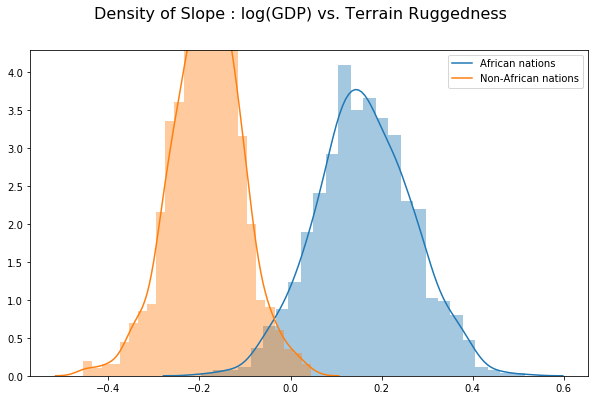

In [53]:
gamma_within_africa = hmc_empirical[:, 2] + hmc_empirical[:, 3]
gamma_outside_africa = hmc_empirical[:, 2]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness", fontsize=16)

In [93]:
hmc_empirical

array([[ 8.93558979, -1.48155653, -0.05924144,  0.13525887,  0.93616557],
       [ 8.96650505, -1.50333977, -0.04461663,  0.07987453,  1.0455482 ],
       [ 9.03341866, -1.53490925, -0.13957554,  0.25697351,  0.94482905],
       ..., 
       [ 9.06436729, -1.66824532, -0.11816906,  0.05773908,  1.05180895],
       [ 9.06173706, -1.4848609 , -0.09644955,  0.27371079,  1.0345037 ],
       [ 8.98959064, -1.6422596 , -0.1131989 ,  0.21590304,  1.01673794]], dtype=float32)